In [1]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

print("TF:", tf.__version__)
print("GPU:", tf.config.list_physical_devices("GPU"))

# if GPU available, allow memory growth
gpus = tf.config.list_physical_devices("GPU")
if gpus:
    try:
        for g in gpus:
            tf.config.experimental.set_memory_growth(g, True)
        print("GPU memory growth: enabled")
    except Exception as e:
        print("Could not set memory growth:", e)

class_names = [
    "T-shirt/top","Trouser","Pullover","Dress","Coat",
    "Sandal","Shirt","Sneaker","Bag","Ankle boot"
]

TF: 2.19.0
GPU: []


29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Train: (60000, 28, 28) (60000,)
Test : (10000, 28, 28) (10000,)


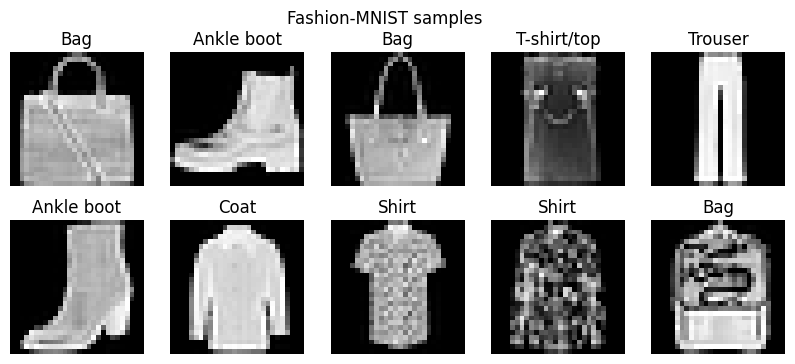

In [2]:
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()
print("Train:", x_train.shape, y_train.shape)
print("Test :", x_test.shape, y_test.shape)

# Split train - train/val
x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train,
    test_size=0.1,
    random_state=SEED,
    stratify=y_train
)

# Normalize to [0,1]
x_train = x_train.astype("float32") / 255.0
x_val   = x_val.astype("float32") / 255.0
x_test  = x_test.astype("float32") / 255.0

# Quick visualization
plt.figure(figsize=(10,4))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(x_train[i], cmap="gray")
    plt.title(class_names[y_train[i]])
    plt.axis("off")
plt.suptitle("Fashion-MNIST samples")
plt.show()

In [3]:
def plot_history(history, title_prefix="Model"):
    hist = history.history

    plt.figure(figsize=(7,4))
    plt.plot(hist.get("loss", []), label="train")
    plt.plot(hist.get("val_loss", []), label="val")
    plt.title(f"{title_prefix}: Loss")
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.grid(True); plt.legend()
    plt.show()

    plt.figure(figsize=(7,4))
    plt.plot(hist.get("accuracy", []), label="train")
    plt.plot(hist.get("val_accuracy", []), label="val")
    plt.title(f"{title_prefix}: Accuracy")
    plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.grid(True); plt.legend()
    plt.show()

def evaluate_and_report(model, x, y, title="Model", show_cm=True):
    test_loss, test_acc = model.evaluate(x, y, verbose=0)
    print(f"\n[{title}] Test loss: {test_loss:.4f} | Test accuracy: {test_acc:.4f}")

    y_prob = model.predict(x, verbose=0)
    y_pred = np.argmax(y_prob, axis=1)

    print("\nClassification report:")
    print(classification_report(y, y_pred, target_names=class_names, digits=4))

    if show_cm:
        cm = confusion_matrix(y, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
        plt.figure(figsize=(9,8))
        disp.plot(xticks_rotation=45, values_format="d")
        plt.title(f"Confusion Matrix: {title}")
        plt.show()

    return test_acc, test_loss, y_pred

def show_random_predictions(model, x, y, title="Predictions", n=10):
    idx = np.random.choice(len(x), size=n, replace=False)
    y_prob = model.predict(x[idx], verbose=0)
    y_pred = np.argmax(y_prob, axis=1)

    plt.figure(figsize=(12,5))
    for i, k in enumerate(idx):
        plt.subplot(2,5,i+1)
        plt.imshow(x[k], cmap="gray")
        plt.axis("off")
        plt.title(f"T:{class_names[y[k]]}\nP:{class_names[y_pred[i]]}")
    plt.suptitle(title)
    plt.show()

    mistakes = int(np.sum(y[idx] != y_pred))
    print(f"Mistakes in these {n} images: {mistakes}/{n}")

def show_top_mistakes(model, x, y, n=12, title="Top mistakes"):
    y_prob = model.predict(x, verbose=0)
    y_pred = np.argmax(y_prob, axis=1)
    probs  = np.max(y_prob, axis=1)

    wrong = np.where(y_pred != y)[0]
    if len(wrong) == 0:
        print("No mistakes")
        return

    # take the most confident wrong predictions
    wrong_sorted = wrong[np.argsort(-probs[wrong])]
    pick = wrong_sorted[:n]

    cols = 6
    rows = int(np.ceil(n / cols))
    plt.figure(figsize=(14, 3.2*rows))
    for i, idx in enumerate(pick):
        plt.subplot(rows, cols, i+1)
        plt.imshow(x[idx], cmap="gray")
        plt.axis("off")
        plt.title(f"T:{class_names[y[idx]]}\nP:{class_names[y_pred[idx]]}\nconf:{probs[idx]:.2f}")
    plt.suptitle(title)
    plt.show()

In [4]:
def make_ds(x, y, batch=256, shuffle=False):
    ds = tf.data.Dataset.from_tensor_slices((x, y))
    if shuffle:
        ds = ds.shuffle(buffer_size=min(len(x), 20000), seed=SEED, reshuffle_each_iteration=True)
    ds = ds.batch(batch).prefetch(tf.data.AUTOTUNE)
    return ds

In [5]:
def build_mlp(
    units1=512,
    units2=256,
    dropout1=0.3,
    dropout2=0.3,
    lr=1e-3,
    use_batchnorm=True,
    activation="relu"
):
    model = keras.Sequential(name="MLP_FashionMNIST")
    model.add(layers.Input(shape=(28,28)))
    model.add(layers.Flatten())

    model.add(layers.Dense(units1, use_bias=not use_batchnorm))
    if use_batchnorm:
        model.add(layers.BatchNormalization())
    model.add(layers.Activation(activation))
    model.add(layers.Dropout(dropout1))

    model.add(layers.Dense(units2, use_bias=not use_batchnorm))
    if use_batchnorm:
        model.add(layers.BatchNormalization())
    model.add(layers.Activation(activation))
    model.add(layers.Dropout(dropout2))

    model.add(layers.Dense(10, activation="softmax"))

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

Epoch 1/25
211/211 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.6625 - loss: 0.9596 - val_accuracy: 0.8540 - val_loss: 0.4085 - learning_rate: 0.0010
Epoch 2/25
211/211 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8336 - loss: 0.4645 - val_accuracy: 0.8702 - val_loss: 0.3660 - learning_rate: 0.0010
Epoch 3/25
211/211 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8537 - loss: 0.4092 - val_accuracy: 0.8808 - val_loss: 0.3350 - learning_rate: 0.0010
Epoch 4/25
211/211 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8627 - loss: 0.3799 - val_accuracy: 0.8805 - val_loss: 0.3307 - learning_rate: 0.0010
Epoch 5/25
211/211 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.8652 - loss: 0.3670 - val_accuracy: 0.8835 - val_loss: 0.3170 - learning_rate: 0.0010
Epoch 6/25
211/211 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.8736 - loss: 0.3436 - val_accuracy: 0.8838 - val_loss: 0.3119 - learning_rate: 0.0010
Epoch 7/25
211/211 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.8753 - loss: 0.

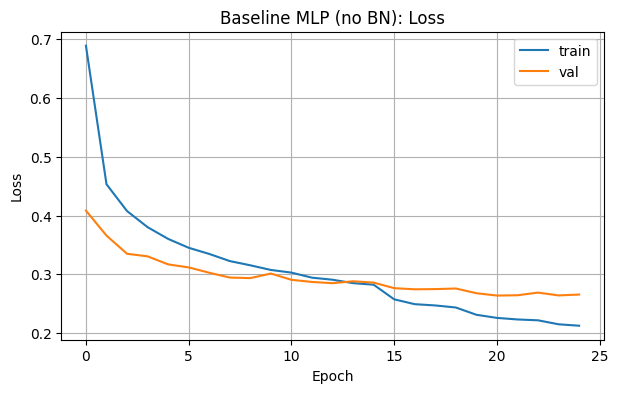

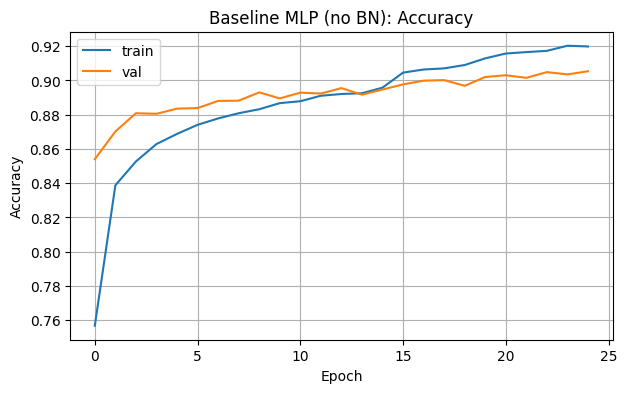


[Baseline MLP (no BN)] Test loss: 0.3076 | Test accuracy: 0.8938

Classification report:
              precision    recall  f1-score   support

 T-shirt/top     0.8538    0.8410    0.8474      1000
     Trouser     0.9919    0.9770    0.9844      1000
    Pullover     0.8235    0.7980    0.8106      1000
       Dress     0.8931    0.8940    0.8936      1000
        Coat     0.7906    0.8420    0.8155      1000
      Sandal     0.9788    0.9680    0.9734      1000
       Shirt     0.7190    0.7140    0.7165      1000
     Sneaker     0.9445    0.9700    0.9571      1000
         Bag     0.9780    0.9760    0.9770      1000
  Ankle boot     0.9696    0.9580    0.9638      1000

    accuracy                         0.8938     10000
   macro avg     0.8943    0.8938    0.8939     10000
weighted avg     0.8943    0.8938    0.8939     10000



<Figure size 900x800 with 0 Axes>

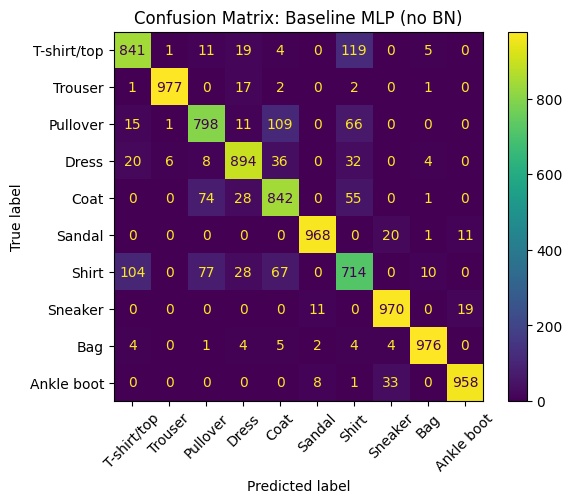

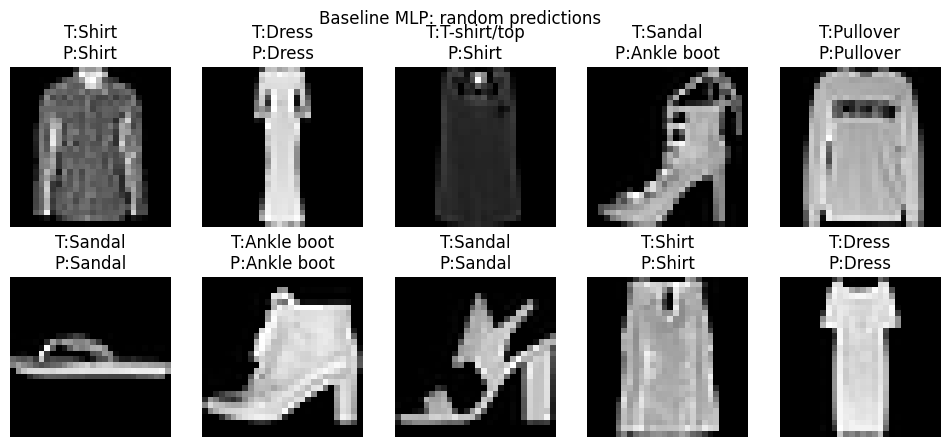

Mistakes in these 10 images: 2/10


In [6]:
baseline = build_mlp(
    units1=256, units2=128,
    dropout1=0.3, dropout2=0.3,
    lr=1e-3, use_batchnorm=False
)

baseline_callbacks = [
    keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=4, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, min_lr=1e-6)
]

hist_base = baseline.fit(
    make_ds(x_train, y_train, batch=256, shuffle=True),
    validation_data=make_ds(x_val, y_val, batch=256),
    epochs=25,
    verbose=1,
    callbacks=baseline_callbacks
)

plot_history(hist_base, "Baseline MLP (no BN)")
base_acc, base_loss, _ = evaluate_and_report(baseline, x_test, y_test, "Baseline MLP (no BN)")
show_random_predictions(baseline, x_test, y_test, "Baseline MLP: random predictions", n=10)

In [7]:
search_space = {
    "units1":      [512, 768],
    "units2":      [256, 384],
    "dropout1":    [0.25, 0.35],
    "dropout2":    [0.25, 0.35],
    "lr":          [1e-3, 5e-4],
    "batch":       [128, 256],
    "use_bn":      [True],
    "activation":  ["relu"],
}

def run_one_config(cfg, max_epochs=20):
    model = build_mlp(
        units1=cfg["units1"],
        units2=cfg["units2"],
        dropout1=cfg["dropout1"],
        dropout2=cfg["dropout2"],
        lr=cfg["lr"],
        use_batchnorm=cfg["use_bn"],
        activation=cfg["activation"]
    )

    callbacks = [
        keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=4, restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, min_lr=1e-6)
    ]

    hist = model.fit(
        make_ds(x_train, y_train, batch=cfg["batch"], shuffle=True),
        validation_data=make_ds(x_val, y_val, batch=cfg["batch"]),
        epochs=max_epochs,
        verbose=0,
        callbacks=callbacks
    )

    best_val_acc = float(np.max(hist.history["val_accuracy"]))
    best_epoch = int(np.argmax(hist.history["val_accuracy"]) + 1)
    return model, hist, best_val_acc, best_epoch

# Build list of configs
configs = []
for u1 in search_space["units1"]:
    for u2 in search_space["units2"]:
        for d1 in search_space["dropout1"]:
            for d2 in search_space["dropout2"]:
                for lr in search_space["lr"]:
                    for bs in search_space["batch"]:
                        cfg = {
                            "units1": u1, "units2": u2,
                            "dropout1": d1, "dropout2": d2,
                            "lr": lr, "batch": bs,
                            "use_bn": True,
                            "activation": "relu",
                        }
                        configs.append(cfg)

print(f"Total configs to try: {len(configs)}")

results = []
best = {"val_acc": -1, "cfg": None, "model": None, "hist": None}

for i, cfg in enumerate(configs, 1):
    model, hist, val_acc, best_epoch = run_one_config(cfg, max_epochs=20)
    results.append((val_acc, best_epoch, cfg))
    print(f"[{i:02d}/{len(configs)}] val_acc={val_acc:.4f} best_epoch={best_epoch} cfg={cfg}")

    if val_acc > best["val_acc"]:
        best.update({"val_acc": val_acc, "cfg": cfg, "model": model, "hist": hist})

print("\nBEST CONFIG:")
print("best val_acc:", best["val_acc"])
print("cfg:", best["cfg"])

Total configs to try: 64
[01/64] val_acc=0.9080 best_epoch=9 cfg={'units1': 512, 'units2': 256, 'dropout1': 0.25, 'dropout2': 0.25, 'lr': 0.001, 'batch': 128, 'use_bn': True, 'activation': 'relu'}
[02/64] val_acc=0.9143 best_epoch=18 cfg={'units1': 512, 'units2': 256, 'dropout1': 0.25, 'dropout2': 0.25, 'lr': 0.001, 'batch': 256, 'use_bn': True, 'activation': 'relu'}
[03/64] val_acc=0.9125 best_epoch=20 cfg={'units1': 512, 'units2': 256, 'dropout1': 0.25, 'dropout2': 0.25, 'lr': 0.0005, 'batch': 128, 'use_bn': True, 'activation': 'relu'}
[04/64] val_acc=0.9088 best_epoch=10 cfg={'units1': 512, 'units2': 256, 'dropout1': 0.25, 'dropout2': 0.25, 'lr': 0.0005, 'batch': 256, 'use_bn': True, 'activation': 'relu'}
[05/64] val_acc=0.9133 best_epoch=17 cfg={'units1': 512, 'units2': 256, 'dropout1': 0.25, 'dropout2': 0.35, 'lr': 0.001, 'batch': 128, 'use_bn': True, 'activation': 'relu'}
[06/64] val_acc=0.9127 best_epoch=20 cfg={'units1': 512, 'units2': 256, 'dropout1': 0.25, 'dropout2': 0.35, '

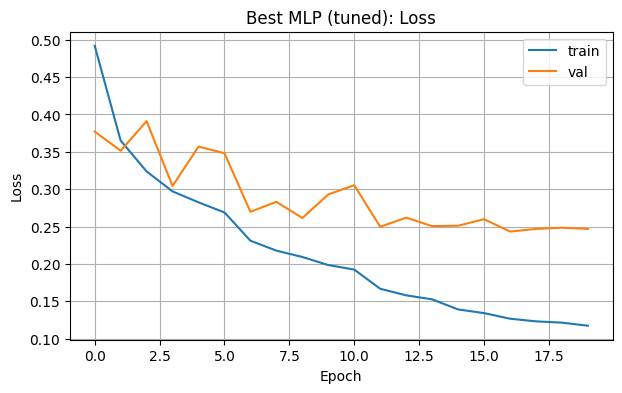

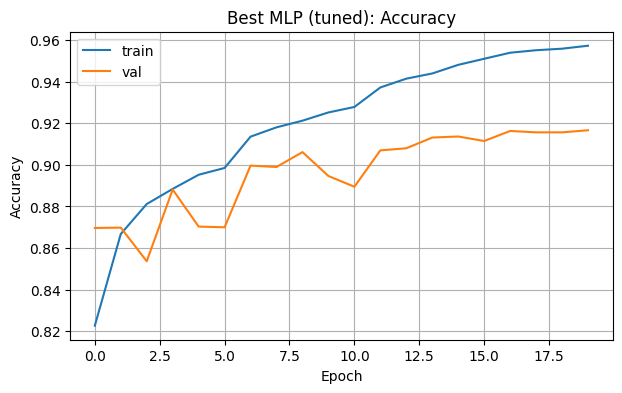


[Best MLP (tuned)] Test loss: 0.3024 | Test accuracy: 0.9036

Classification report:
              precision    recall  f1-score   support

 T-shirt/top     0.8396    0.8740    0.8564      1000
     Trouser     0.9889    0.9800    0.9844      1000
    Pullover     0.8021    0.8590    0.8296      1000
       Dress     0.9034    0.9070    0.9052      1000
        Coat     0.8480    0.8370    0.8425      1000
      Sandal     0.9788    0.9700    0.9744      1000
       Shirt     0.7737    0.7010    0.7356      1000
     Sneaker     0.9517    0.9660    0.9588      1000
         Bag     0.9829    0.9750    0.9789      1000
  Ankle boot     0.9651    0.9670    0.9660      1000

    accuracy                         0.9036     10000
   macro avg     0.9034    0.9036    0.9032     10000
weighted avg     0.9034    0.9036    0.9032     10000



<Figure size 900x800 with 0 Axes>

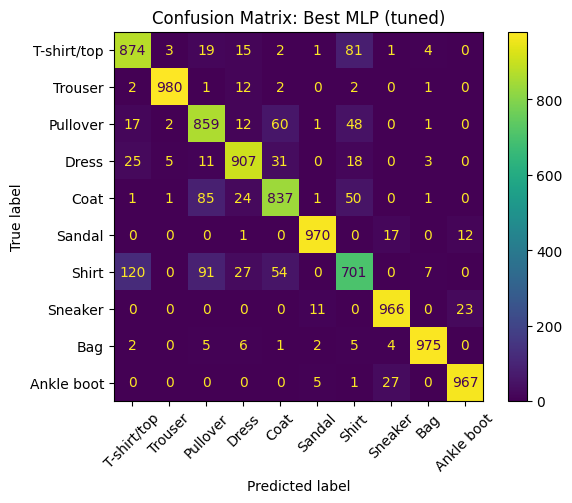

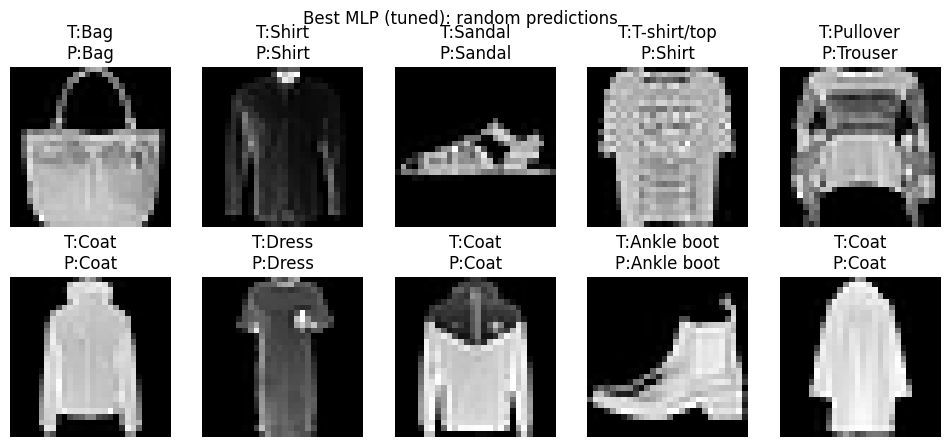

Mistakes in these 10 images: 2/10


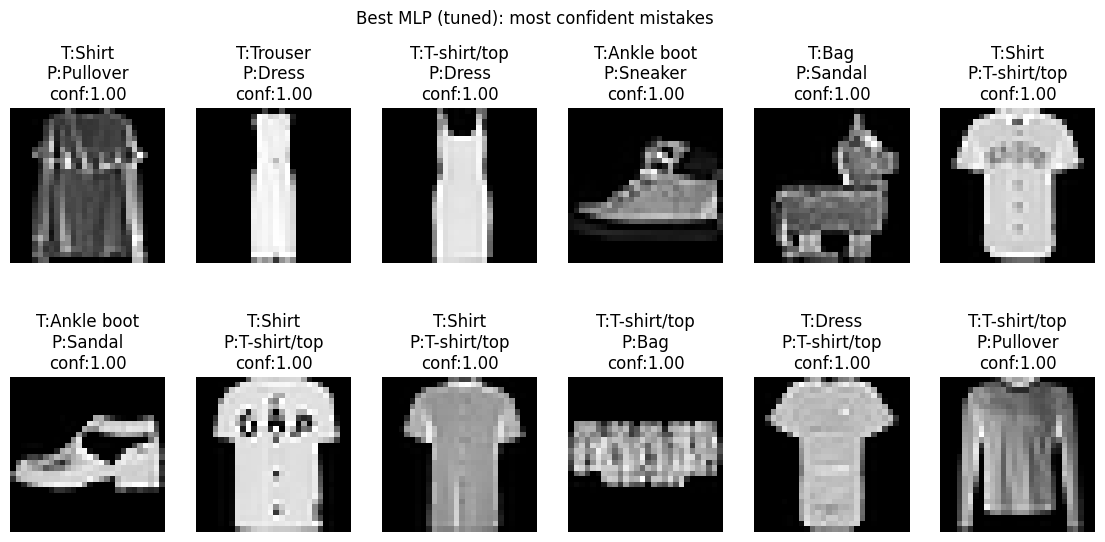

In [8]:
plot_history(best["hist"], "Best MLP (tuned)")

# Evaluate best on test
tuned_acc, tuned_loss, tuned_pred = evaluate_and_report(best["model"], x_test, y_test, "Best MLP (tuned)")
show_random_predictions(best["model"], x_test, y_test, "Best MLP (tuned): random predictions", n=10)
show_top_mistakes(best["model"], x_test, y_test, n=12, title="Best MLP (tuned): most confident mistakes")

In [9]:
print("\nFINAL COMPARISON")
print(f"Baseline test acc: {base_acc:.4f}")
print(f"Tuned    test acc: {tuned_acc:.4f}")


FINAL COMPARISON
Baseline test acc: 0.8938
Tuned    test acc: 0.9036


In [10]:
os.makedirs("artifacts", exist_ok=True)
best["model"].save("artifacts/fashion_mnist_mlp_tuned.keras")
print("Saved: artifacts/fashion_mnist_mlp_tuned.keras")

Saved: artifacts/fashion_mnist_mlp_tuned.keras
